# Phase 2 : Behavioral Classification

This codebook takes in the post estimations (from deeplabcut), and train XGBoost Model to predict bahaviors of mice.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import Pose Estimation File and Process

In [ ]:
# Function to import post estimation data for training
def import_post_estimation_data(trial_numbers, path):
    """
    Imports and processes post-estimation data for specified trial numbers.
    Args:
        trial_numbers (list of int): List of trial numbers to process.
        path (str): Directory path containing the files.
    Returns:
        pd.DataFrame: Combined DataFrame for the specified trials.
    """
    dataframes = []

    for filename in os.listdir(path):
        # extract the trial number from the file name
        trial = int(filename.split('Trial ')[1].split('DLC')[0])

        # Process the file only if it's in the specified trial numbers
        if trial in trial_numbers:
            file_path = os.path.join(path, filename)
            processed_df = process_file(file_path, trial)
            dataframes.append(processed_df)

    # Concatenate all DataFrames and return
    return pd.concat(dataframes, ignore_index=True)

def process_file(path, trial_value, threshold=0.4):
    """
    Reads, processes, and cleans a post-estimation file.
    Args:
        path (str): Path to the file.
        trial_value (int): Trial number.
        threshold (float): Threshold for filtering low-likelihood rows.
    Returns:
        pd.DataFrame: Cleaned and processed DataFrame for the trial.
    """
    # Read the CSV file
    df = pd.read_csv(path, header=None)
    df = df.drop(index=0)
    df.columns = [
        f"{bp.strip()}_{coord.strip()}" if bp.strip() != "" else coord.strip()
        for bp, coord in zip(df.iloc[0], df.iloc[1])
    ]
    df = df.drop(index=[1, 2]).reset_index(drop=True)
    df['trial'] = trial_value

    # Convert all columns to float
    df = df.astype(float)

    # Filter based on likelihood
    for column in df.columns:
        if "likelihood" in column:
            # Identify the body part by removing '_likelihood' from the column name
            body_part = column.replace("_likelihood", "")

            # Find rows where likelihood is below the threshold
            filtered = df[column] < threshold

            # Set the corresponding x and y coordinates to NaN for those rows
            df.loc[filtered, f"{body_part}_x"] = np.nan
            df.loc[filtered, f"{body_part}_y"] = np.nan

    # Rename columns
    df = df.rename(columns={'bodyparts_coords': 'frame'})

    # Adjust data types
    df[['frame', 'trial']] = df[['frame', 'trial']].astype(int)

    # Drop likelihood columns
    df = df[df.columns[~df.columns.str.contains("likelihood")]]

    # Fill missing values
    df = df.fillna(-1000)

    return df

In [ ]:
# File Path
path = '/content/drive/MyDrive/capstone/Phase 2 Wrap Up/experiment videos filtered csv'

# List of trial numbers to use for training
trial_numbers = [15, 16, 17, 18, 20, 21, 37, 38, 39, 40, 41, 42]

# Import data
training_data = import_post_estimation_data(trial_numbers, path)

# Display the combined DataFrame
display(training_data)

,frame,nose_x,nose_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,spine_middle_x,spine_middle_y,tail_base_x,tail_base_y,tail_middle_x,tail_middle_y,tail_tip_x,tail_tip_y,trial
0,0,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,16
1,1,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,16
2,2,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,16
3,3,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,16
4,4,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43495,2744,345.58002,193.14027,357.13300,196.88792,355.11566,185.16295,363.03230,188.59276,383.05112,185.97990,398.89780,176.95920,410.02673,185.20757,42
43496,2745,344.72162,191.86247,356.04187,196.75950,354.82080,184.72272,362.59660,188.58453,382.70514,185.89930,400.00986,177.23251,409.86417,185.31203,42
43497,2746,344.72162,191.78624,356.04187,196.71431,354.82080,184.54646,362.59660,188.41505,382.70175,185.89930,400.00986,177.24373,409.86320,185.31203,42
43498,2747,344.61707,191.76437,355.83746,196.67590,354.72310,184.51134,362.33030,188.40018,382.69610,185.88402,400.00986,177.24373,409.86090,185.31203,42


#### Import annotation file and merge with pose estimation data

Behaviors are classfied to be one of the following:
- Others (O): Mice does not exist in the frame
- Wondering(W): Mice is wondering around in the box
- Investigating(I): Mice is around the pot and investigate the pot
- Digging (D): Mice is digging the pot

In [ ]:
def process_annotation_data(annotation_path, df, fps=30):
    """
    Processes the behavioral annotation data, generates full frames for each trial,
    and interpolates missing values.
    Args:
        annotation_path (str): Path to the annotation CSV file.
        df (pd.DataFrame): Post-estimation data containing 'trial' and 'frame' columns.
        fps (int): Frames per second used for calculating frame numbers.
    Returns:
        pd.DataFrame: Processed annotation data with full frames and interpolated behavior labels.
    """
    # Read annotation data
    data = pd.read_csv(annotation_path)

    # Extract 'Behavior' column as the label with the highest value
    data['Behavior'] = data.iloc[:, 2:].idxmax(axis=1)

    # Select necessary columns
    anno = data[['trial', 'time', 'Behavior']]

    # Calculate frame numbers based on time
    anno['frame'] = (fps * anno['time']).astype(int)

    # Convert behaviors to their initials
    anno['Behavior'] = anno['Behavior'].str[0]

    # Generate full frames for each trial based on the post-estimation data
    max_frames = df.groupby('trial')['frame'].max()
    full_frames = pd.DataFrame(
        [(trial, frame) for trial, max_frame in max_frames.items() for frame in range(max_frame + 1)],
        columns=['trial', 'frame']
    )

    # Merge full frames with annotation data
    merged = pd.merge(full_frames, anno, on=['trial', 'frame'], how='left')

    # Interpolate missing time values
    merged['time'] = merged['time'].interpolate(method='linear')

    # Fill missing behavior labels using forward and backward fill
    merged['Behavior'] = merged['Behavior'].fillna(method='ffill').fillna(method='bfill')

    return merged

def merge_with_post_estimation(post_estimation_df, annotation_df):
    """
    Merges the post-estimation data with the processed annotation data.
    Args:
        post_estimation_df (pd.DataFrame): Post-estimation data containing 'trial' and 'frame'.
        annotation_df (pd.DataFrame): Processed annotation data with 'trial', 'frame', and 'Behavior'.
    Returns:
        pd.DataFrame: Merged DataFrame with sorted and reset index.
    """
    merged_data = pd.merge(post_estimation_df, annotation_df, on=['frame', 'trial'])
    merged_data = merged_data.sort_values(by=['trial', 'frame'], ascending=[True, True])
    merged_data = merged_data.reset_index(drop=True)
    return merged_data

In [ ]:
# File paths
annotation_path = '/content/drive/MyDrive/capstone/Phase 2 Wrap Up/Behavior Annotation.csv'

# Process annotation data, including generating full frames
annotation_data = process_annotation_data(annotation_path, training_data)

# Merge processed annotation data with post-estimation data
merged_data = merge_with_post_estimation(training_data, annotation_data)

# Display the final result
display(merged_data)


<ipython-input-16-892192f1c778>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno['frame'] = (fps * anno['time']).astype(int)
<ipython-input-16-892192f1c778>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno['Behavior'] = anno['Behavior'].str[0]
<ipython-input-16-892192f1c778>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['Behavior'] = merged['Behavior'].fillna(method='ffill').fillna(method='bfill')

,frame,nose_x,nose_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,spine_middle_x,spine_middle_y,tail_base_x,tail_base_y,tail_middle_x,tail_middle_y,tail_tip_x,tail_tip_y,trial,time,Behavior
0,0,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,0.000000,O
1,1,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,0.033333,O
2,2,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,0.066667,O
3,3,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,0.100000,O
4,4,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,0.133333,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43495,2744,345.58002,193.14027,357.13300,196.88792,355.11566,185.16295,363.03230,188.59276,383.05112,185.97990,398.89780,176.95920,410.02673,185.20757,42,91.466667,D
43496,2745,344.72162,191.86247,356.04187,196.75950,354.82080,184.72272,362.59660,188.58453,382.70514,185.89930,400.00986,177.23251,409.86417,185.31203,42,91.500000,D
43497,2746,344.72162,191.78624,356.04187,196.71431,354.82080,184.54646,362.59660,188.41505,382.70175,185.89930,400.00986,177.24373,409.86320,185.31203,42,91.533333,D
43498,2747,344.61707,191.76437,355.83746,196.67590,354.72310,184.51134,362.33030,188.40018,382.69610,185.88402,400.00986,177.24373,409.86090,185.31203,42,91.566667,D


#### Train XGBoost

In [ ]:
def train_behavior_model(merged_data, order=["O", "W", "I", "D"], test_size=0.2, random_state=42):
    """
    Trains an XGBoost model for behavior classification and adds predictions to the data.
    Args:
        merged_data (pd.DataFrame): Merged DataFrame containing 'Behavior' and other data.
        order (list of str): Ordered list of behavior categories for encoding.
        test_size (float): Proportion of data to be used as the test set.
        random_state (int): Random state for reproducibility.
    Returns:
        XGBClassifier: Trained XGBoost model.
        pd.DataFrame: DataFrame with predicted behaviors added.
    """
    # Step 1: Encode behavior labels
    labels = pd.Categorical(merged_data["Behavior"], categories=order, ordered=True).codes

    # Step 2: Extract features
    features = merged_data.iloc[:, 1:15]  # Exclude 'frame', 'trial','time', 'Behavior'

    # Step 3: Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, shuffle=True, stratify=labels
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)

    # Step 4: Train the XGBoost classifier
    xgb = XGBClassifier(eval_metric="logloss")
    cross_val_scores = cross_val_score(xgb, X_train_standardized, y_train, cv=5, scoring="accuracy")
    print("Cross-validation scores:", cross_val_scores)
    print("Mean accuracy:", cross_val_scores.mean())
    xgb.fit(X_train_standardized, y_train)

    # Step 5: Make predictions
    features_standardized = scaler.transform(features)
    merged_data["Predicted_Behavior"] = xgb.predict(features_standardized)

    # Step 6: Add encoded behavior labels and drop unnecessary columns
    merged_data["Behavior_encoded"] = pd.Categorical(merged_data["Behavior"], categories=order, ordered=True).codes
    merged_data = merged_data.drop(columns=["time"], errors="ignore")

    # Output accuracy on the test set
    y_pred = xgb.predict(X_test_standardized)
    print("Test set accuracy:", accuracy_score(y_test, y_pred))

    return xgb, scaler, merged_data, features, labels

In [ ]:
# Train the model and get the updated dataset with predictions
trained_model, trained_scaler, updated_data, training_features, training_labels = train_behavior_model(merged_data)

# Display the updated DataFrame with predictions
display(updated_data)

Cross-validation scores: [0.98448276 0.98045977 0.98103448 0.98017241 0.98074713]
Mean accuracy: 0.9813793103448276
Test set accuracy: 0.9788505747126437


,frame,nose_x,nose_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,spine_middle_x,spine_middle_y,tail_base_x,tail_base_y,tail_middle_x,tail_middle_y,tail_tip_x,tail_tip_y,trial,Behavior,Predicted_Behavior,Behavior_encoded
0,0,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,O,0,0
1,1,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,O,0,0
2,2,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,O,0,0
3,3,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,O,0,0
4,4,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,-1000.00000,15,O,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43495,2744,345.58002,193.14027,357.13300,196.88792,355.11566,185.16295,363.03230,188.59276,383.05112,185.97990,398.89780,176.95920,410.02673,185.20757,42,D,3,3
43496,2745,344.72162,191.86247,356.04187,196.75950,354.82080,184.72272,362.59660,188.58453,382.70514,185.89930,400.00986,177.23251,409.86417,185.31203,42,D,3,3
43497,2746,344.72162,191.78624,356.04187,196.71431,354.82080,184.54646,362.59660,188.41505,382.70175,185.89930,400.00986,177.24373,409.86320,185.31203,42,D,3,3
43498,2747,344.61707,191.76437,355.83746,196.67590,354.72310,184.51134,362.33030,188.40018,382.69610,185.88402,400.00986,177.24373,409.86090,185.31203,42,D,3,3


# Test Model on Unseen Data

We left out trail 51 to test model performances

In [ ]:
def test_trial(path, trained_model, scaler, behavior_order, feature_columns):
    """
    Processes a trial file, predicts behaviors using a trained model, and returns updated data.
    Args:
        path (str): Path to the trial file.
        trained_model (XGBClassifier): Trained XGBoost model for behavior classification.
        scaler (StandardScaler): Fitted scaler for feature standardization.
        behavior_order (list of str): Ordered list of behavior categories for encoding.
        feature_columns (list of str): List of feature column names for prediction.
    Returns:
        pd.DataFrame: DataFrame with predicted behaviors.
    """
    # Step 1: Read and process the trial file
    trial_data = pd.read_csv(path)

    # Handle 'P' behavior replacement (if needed)
    trial_data['Behavior'] = trial_data['Behavior'].replace({'P': 'D'})

    # Step 2: Extract features and standardize them
    features = trial_data[feature_columns]
    standardized_features = scaler.transform(features)

    # Step 3: Predict behaviors
    predicted_labels = trained_model.predict(standardized_features)
    trial_data["Predicted_Behavior"] = predicted_labels

    # Step 4: Encode true behavior labels
    trial_data["Behavior_encoded"] = pd.Categorical(
        trial_data["Behavior"], categories=behavior_order, ordered=True
    ).codes

    # Step 5: Calculate and print accuracy
    accuracy = accuracy_score(trial_data["Behavior_encoded"], trial_data["Predicted_Behavior"])
    print(f"Accuracy for trial in {path}: {accuracy:.2f}")

    # Step 6: Plot true vs predicted behaviors
    plt.figure(figsize=(15, 5))
    plt.plot(trial_data["Behavior_encoded"], label="True Behavior", alpha=0.7)
    plt.plot(trial_data["Predicted_Behavior"], label="Predicted Behavior", alpha=0.7)
    plt.legend()
    plt.title(f"True vs Predicted Behavior for Trial ({path.split('/')[-1]})")
    plt.xlabel("Frame")
    plt.ylabel("Behavior")
    plt.show()

    return trial_data

Accuracy for trial in /content/drive/MyDrive/capstone/Phase 2 Wrap Up/trial51.csv: 0.87


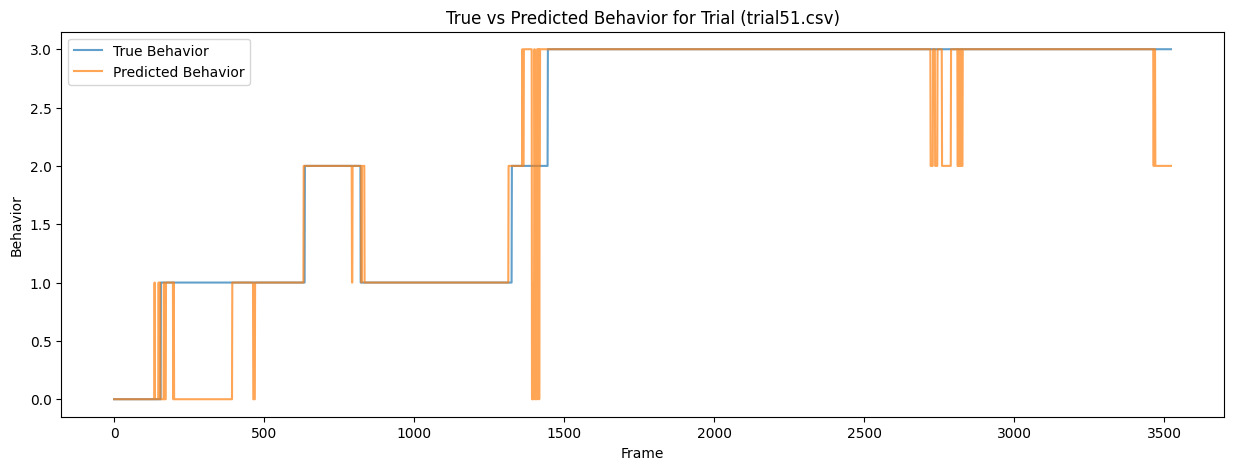

In [ ]:
# Paths to trial files
trial_51_path = '/content/drive/MyDrive/capstone/Phase 2 Wrap Up/trial51.csv'

# Define feature columns and behavior order
feature_columns = updated_data.columns[1:15]  # Replace with actual feature column names
behavior_order = ["O", "W", "I", "D"]

# Process and predict for Trial 51
trial_51_data = test_trial(
    trial_51_path, trained_model=trained_model, scaler=trained_scaler,
    behavior_order=behavior_order, feature_columns=feature_columns
)

# Predict unlabeled videos

In [ ]:
def predict_unlabeled_videos(
    all_files_path, train_trial_numbers, save_path, trained_model, scaler, feature_columns, behavior_order, fps=30
):
    """
    Predicts behaviors for unlabeled videos, adds predictions and time column, and saves the results.
    Args:
        all_files_path (str): Path to the directory containing all video files.
        train_trial_numbers (list of int): List of trial numbers used for training (exclude these from prediction).
        save_path (str): Path to save the predicted files.
        trained_model (XGBClassifier): Trained XGBoost model.
        scaler (StandardScaler): Fitted scaler for feature standardization.
        feature_columns (list of str): List of feature column names for prediction.
        behavior_order (list of str): Ordered list of behavior categories for encoding.
        fps (int): Frames per second to calculate the time column.
    """
    # Iterate over all files in the directory
    for filename in os.listdir(all_files_path):
        # Extract the trial number from the file name
        trial = int(filename.split('Trial ')[1].split('DLC')[0])

        # Skip files belonging to training trials
        if trial in train_trial_numbers:
            continue

        file_path = os.path.join(all_files_path, filename)
        print(f"Processing file: {filename} (Trial {trial})")

        # Step 1: Read and process the file
        trial_data = pd.read_csv(file_path)
        trial_data = process_file(file_path, trial)

        # Step 2: Add time column (if frame column exists)
        trial_data["time"] = trial_data["frame"] / fps

        # Step 3: Extract features and standardize them
        features = trial_data[feature_columns]
        standardized_features = scaler.transform(features)

        # Step 4: Predict behaviors
        predicted_labels = trained_model.predict(standardized_features)
        trial_data["Predicted_Behavior_encoded"] = predicted_labels

        # Step 5: Map predicted labels back to behavior categories
        trial_data["Predicted_Behavior"] = pd.Categorical.from_codes(
            predicted_labels, categories=behavior_order, ordered=True
        ).astype(str)  # Convert back to string representation

        # Step 6: Save the updated DataFrame
        save_file_path = os.path.join(save_path, filename)
        trial_data.to_csv(save_file_path, index=False)
        print(f"Saved predictions to: {save_file_path}")

    print("All unlabeled videos processed and saved.")

In [ ]:
# Define paths and parameters
all_files_path = '/content/drive/MyDrive/capstone/Phase 2 Wrap Up/experiment videos filtered csv'
train_trial_numbers = [15, 16, 17, 18, 20, 21, 37, 38, 39, 40, 41, 42]
save_path = '/content/drive/MyDrive/capstone/Phase 2 Wrap Up/Videos with predicted labels'
feature_columns = updated_data.columns[1:15]  # Replace with actual feature column names
behavior_order = ["O", "W", "I", "D"]

In [ ]:
# Predict unlabeled videos
predict_unlabeled_videos(
    all_files_path, train_trial_numbers, save_path,
    trained_model=trained_model, scaler=trained_scaler,
    feature_columns=feature_columns, behavior_order=behavior_order, fps= 30
)

Processing file: Trial 100DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv (Trial 100)
Saved predictions to: /content/drive/MyDrive/capstone/Phase 2 Wrap Up/Videos with predicted labels/Trial 100DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv
Processing file: Trial 25DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv (Trial 25)
Saved predictions to: /content/drive/MyDrive/capstone/Phase 2 Wrap Up/Videos with predicted labels/Trial 25DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv
Processing file: Trial 27DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv (Trial 27)
Saved predictions to: /content/drive/MyDrive/capstone/Phase 2 Wrap Up/Videos with predicted labels/Trial 27DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv
Processing file: Trial 30DLC_Resnet50_capstoneTop50Nov8shuffle1_snapshot_015_filtered.csv (Trial 30)
Saved predictions to: /content/drive/MyDrive/capstone/Phase 2 Wrap Up/Videos 